In [1]:
import sys
import os

# Add the directory containing instruments.py to the Python path
custom_module_path = "/home/rebeccaz/Github/vampires_calibration"
sys.path.append(custom_module_path)

import instruments as inst
import numpy as np
import json

# Step 1: Setting up initial information

In [2]:
# Data path for processed csv
file_path = custom_module_path + "/20230914_processed_table.csv"
wavelengths = [610]
obs_modes = ["MBI"]
save_fits_directory = "/home/rebeccaz/Github/vampires_calibration/scipy_minimize/data_files/produced/"
previous_fits_directory = save_fits_directory
em_gains = [1.230573943788524]

# Step 2: Performing fits iteratively by wavelength - first broadband then MBI

{'dichroic': {'phi': 3.7084328914496743, 'epsilon': 8.255879363707094e-12, 'theta': 7.4099947549440826}, 'flc': {'phi': 3.667766217695411, 'delta_theta': 4.999999992194389}, 'optics': {'phi': 5.440040371157072e-10, 'epsilon': 5.3090618914466006e-12, 'theta': -90.0}, 'image_rotator': {'phi': 1.3583383161165345}, 'hwp': {'phi': 2.7444277853375203, 'delta_theta': 2.0828353326781803}, 'lp': {'theta': -1.9553916028194387}}
[[ 0.58219845  0.58084278 -0.03970771  0.        ]
 [ 0.58219845  0.58084278 -0.03970771  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
logl value: 404.42392017563384


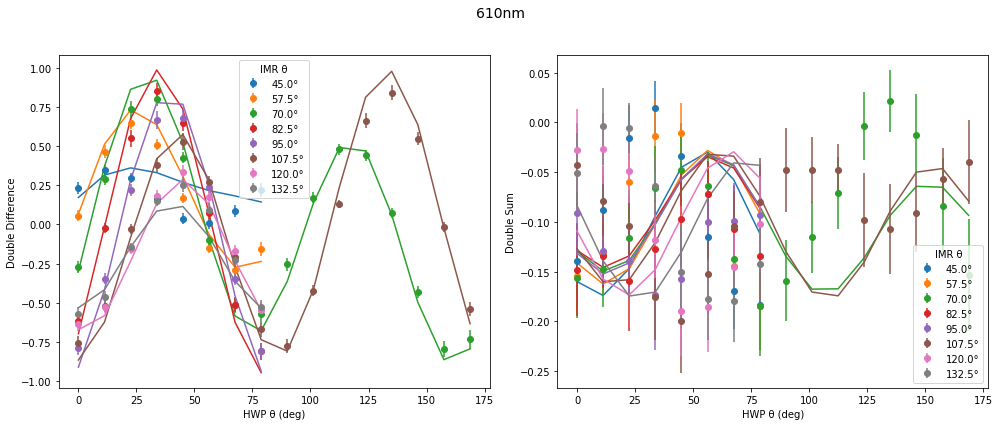

Before p0: {'dichroic': {'phi': 3.7084328914496743, 'epsilon': 8.255879363707094e-12, 'theta': 7.4099947549440826}, 'flc': {'phi': 3.667766217695411, 'delta_theta': 4.999999992194389}, 'optics': {'phi': 5.440040371157072e-10, 'epsilon': 5.3090618914466006e-12, 'theta': -90.0}, 'image_rotator': {'phi': 1.3583383161165345}, 'hwp': {'phi': 2.7444277853375203, 'delta_theta': 2.0828353326781803}, 'lp': {'theta': -1.9553916028194387}}
Iteration #: 1
logl_value: 404.4239200034017
Best Fit Parameters: [ 3.70843780e+00  8.30345347e-12  7.41001710e+00  3.66776297e+00
  4.99999999e+00  5.47538248e-10  5.38967582e-12 -9.00000000e+01
  1.35833832e+00  2.74442779e+00  2.08287520e+00 -1.95525194e+00]


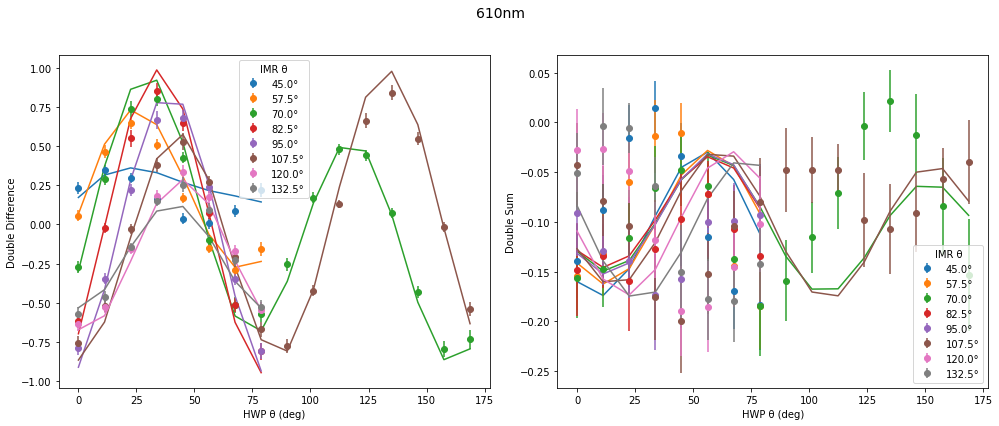

After p0: {'dichroic': {'phi': 3.708437796483225, 'epsilon': 8.303453470992052e-12, 'theta': 7.410017100947227}, 'flc': {'phi': 3.667762969625894, 'delta_theta': 4.99999999399923}, 'optics': {'phi': 5.475382479557536e-10, 'epsilon': 5.389675818625889e-12, 'theta': -90.0}, 'image_rotator': {'phi': 1.3583383160979925}, 'hwp': {'phi': 2.7444277853375203, 'delta_theta': 2.082875202382188}, 'lp': {'theta': -1.9552519446255023}}
Before p0: {'dichroic': {'phi': 3.708437796483225, 'epsilon': 8.303453470992052e-12, 'theta': 7.410017100947227}, 'flc': {'phi': 3.667762969625894, 'delta_theta': 4.99999999399923}, 'optics': {'phi': 5.475382479557536e-10, 'epsilon': 5.389675818625889e-12, 'theta': -90.0}, 'image_rotator': {'phi': 1.3583383160979925}, 'hwp': {'phi': 2.7444277853375203, 'delta_theta': 2.082875202382188}, 'lp': {'theta': -1.9552519446255023}}
Iteration #: 2
logl_value: 404.42391988862585
Best Fit Parameters: [ 3.70843717e+00  1.20321968e-11  7.41002936e+00  3.66776586e+00
  4.99999999e

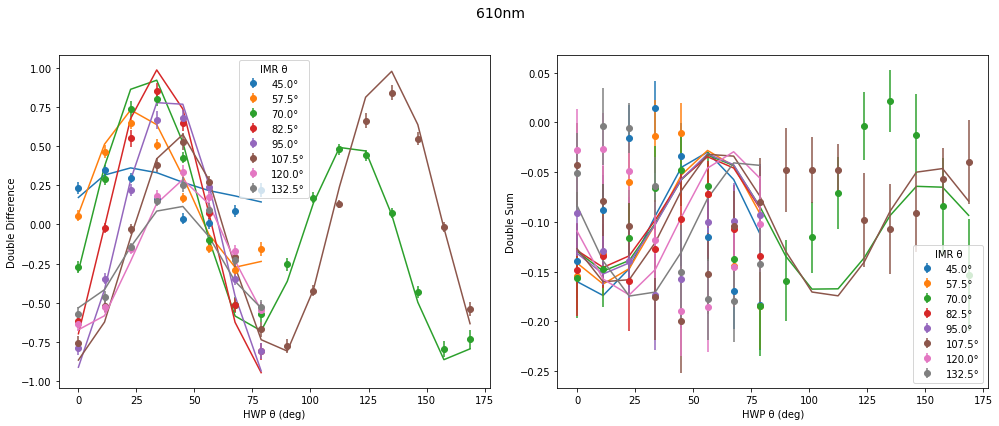

After p0: {'dichroic': {'phi': 3.7084371683676944, 'epsilon': 1.2032196808734686e-11, 'theta': 7.410029355207856}, 'flc': {'phi': 3.6677658600318424, 'delta_theta': 4.9999999946504055}, 'optics': {'phi': 0.0, 'epsilon': 6.6906702457811236e-12, 'theta': -90.0}, 'image_rotator': {'phi': 1.3583383161029075}, 'hwp': {'phi': 2.7444277853375203, 'delta_theta': 2.0830266290126436}, 'lp': {'theta': -1.9548936450203307}}


In [5]:
# Defining wavelength
for i, wavelength in enumerate(wavelengths):
    interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
        obs_mode = obs_modes[i], obs_filter = wavelength)

    filename = "/home/rebeccaz/Github/vampires_calibration/scipy_minimize/data_files/produced/610nm_no_IMR_offset_with_IMR_and_HWP_upper_bounds.txt"

    # Using closest broadband files    
    with open(filename, "r") as f:
        past_fit = json.load(f)
    print(past_fit)

    theta_pol = past_fit["lp"]["theta"]
    delta_HWP = past_fit["hwp"]["phi"] 
    offset_HWP = past_fit["hwp"]["delta_theta"]
    delta_derot = past_fit["image_rotator"]["phi"] 
    delta_opts = past_fit["optics"]["phi"]
    epsilon_opts = past_fit["optics"]["epsilon"]
    rot_opts = past_fit["optics"]["theta"]
    delta_dichroic = past_fit["dichroic"]["phi"]
    epsilon_dichroic = past_fit["dichroic"]["epsilon"]
    rot_dichroic = past_fit["dichroic"]["theta"]
    delta_FLC = past_fit["flc"]["phi"] 
    rot_FLC = past_fit["flc"]["delta_theta"]
    em_gain = em_gains[i] # from EM gain measurements

    # NOTE: Components must be listed downstream to upstream
    # Define the instrument configuration as a system dictionary
    system_dict = {
        "components": {
            "wollaston": {
                "type": "wollaston_prism_function",
                "properties": {"beam": "o", "transmission_ratio": em_gain},
            },
            "dichroic": {
                "type": "diattenuator_retarder_function",
                "properties": {'phi': delta_dichroic, 
                    'epsilon': epsilon_dichroic, 'theta': rot_dichroic},
            },
            "flc": {
                "type": "general_retarder_function",
                "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
            },
            "optics": {
                "type": "diattenuator_retarder_function",
                "properties": {'phi': 2 * np.pi * delta_opts, 
                    'epsilon': epsilon_opts, 'theta': rot_opts},
            },
            "image_rotator": {
                "type": "general_retarder_function",
                "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": 0},
            },
            "hwp": {
                "type": "general_retarder_function",
                "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
            },
            "lp": {
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"theta": theta_pol},
            },
        }
    }

    # Setting bounds
    bounds = [ 
    (0, 2 * np.pi), # dichroic_retardance
    (0, 1), # dichroic_diattenuation
    (-90, 90), # dichroic_rotation_angle 
    (0.25 * 2 * np.pi, 0.75 * 2 * np.pi),  # delta_FLC
    (-5, 5),  # rot_FLC
    (0, 2 * np.pi),  # delta_opts
    (0, 1),  # epsilon_opts
    (-90, 90),  # rot_opts
    (0, delta_derot),  # delta_derot
    (0, delta_HWP),  # delta_HWP
    (-5, 5),  # offset_HWP
    (-5, 5),  # theta_pol
]

    # Turn dictionary into matrix
    system_mm = inst.generate_system_mueller_matrix(system_dict)
    print(system_mm.evaluate())

    # Set-up for p0
    p0 = {
    # "wollaston": {"transmission_ratio": em_gain}, 
    "dichroic": {"phi": np.abs(delta_dichroic), 
                 "epsilon": epsilon_dichroic, 
                 "theta": rot_dichroic},
    "flc": {"phi": delta_FLC, "delta_theta": rot_FLC},
    "optics": {"phi": np.abs(delta_opts), "epsilon": epsilon_opts, "theta": rot_opts},
    "image_rotator": {
                    "phi": delta_derot, 
                    # "delta_theta": 0
                    },
    "hwp": {"phi": delta_HWP, "delta_theta": offset_HWP},
    "lp": {"theta": theta_pol}
    }

    # Adding p0
    p0_values, p0_keywords = inst.parse_configuration(p0)
    s_in = np.array([1, 0, 0, 0])
    logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
        s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
        process_model=inst.process_model)
    print("logl value: " + str(logl_value))

    # Plotting intial plot
    updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
    model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
        process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength)

    # Iterative Fitting
    # Unpolarized light for s_in as there is LP in the system already
    s_in = np.array([1, 0, 0, 0])

    # Counters for iterative fitting
    iteration = 1
    previous_logl_value = 1000000
    new_logl_value = 0

    while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
        print("Before p0: " + str(p0))
        if iteration > 1: 
            previous_logl_value = new_logl_value
        result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
            interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
            process_dataset = inst.process_dataset, 
            process_errors = inst.process_errors, 
            process_model = inst.process_model, bounds = bounds)
        
        # Print statements
        print("Iteration #: " + str(iteration))
        print("logl_value: " + str(new_logl_value))
        print("Best Fit Parameters: " + str(result.x))

        # Making a plot
        updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
        model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
        process_model = inst.process_model)

        save_path = save_fits_directory + str(wavelength) + "nm_no_IMR_offset_with_IMR_and_HWP_upper_bounds_no_FLC_constraints.png"
        inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
            configuration_list, wavelength = wavelength, save_path = save_path)

        # Updating p0 for next time
        inst.update_p0(p0, result.x)
        print("After p0: " + str(p0))

        iteration += 1

        filename = save_fits_directory + str(wavelength) + "nm_no_IMR_offset_with_IMR_and_HWP_upper_bounds_no_FLC_constraints.txt"
        with open(filename, 'w') as f:
            json.dump(p0, f, indent=4)